# Aula 11 (06/10/2023)

# Problema do Transbordo

O Problema do Transbordo é uma mistura dos problemas do transporte e do  caminho mínimo, pois há nós de origem associdados a capacidades que satizfazem nós de destino associados a demandas, mas ele também possui nós intermediários que também estão associados a demandas.

Por exemplo:

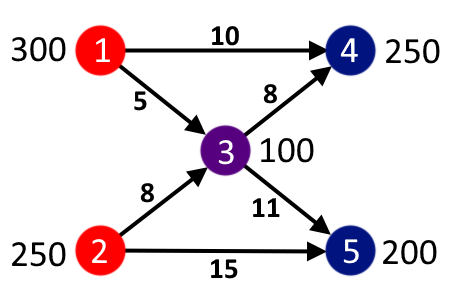

Na forma de um problema de programação linear:

$\text{Minimizar}\ 5X_{13}+ 10X_{14} +8X_{23} +15X_{25} +8X_{34} +11X_{35}$  
$\text{Sujeito a}
    \begin{cases}
        \left. \begin{array}{l}
            -X_{13} -X_{14} = -300 \\
            -X_{23} -X_{25} = -250 \\
        \end{array}\right\}\ \text{Nós de origem} \\
        \left. \begin{array}{l}
            X_{13} +X_{23} -X_{34} -X_{35} = 100 \\
        \end{array}\right\}\ \text{Nós intermediários} \\
        \left. \begin{array}{l}
            X_{14} +X_{34} = 250 \\
            X_{25} +X_{35} = 200 \\
        \end{array}\right\}\ \text{Nós de destino} \\
    X_{13},\ X_{14},\ X_{23},\ X_{25},\ X_{34},\ X_{35} \ge 0
\end{cases}$  

## Exemplo 1

Considere o problema do transbordo representado pelo grafo abaixo:

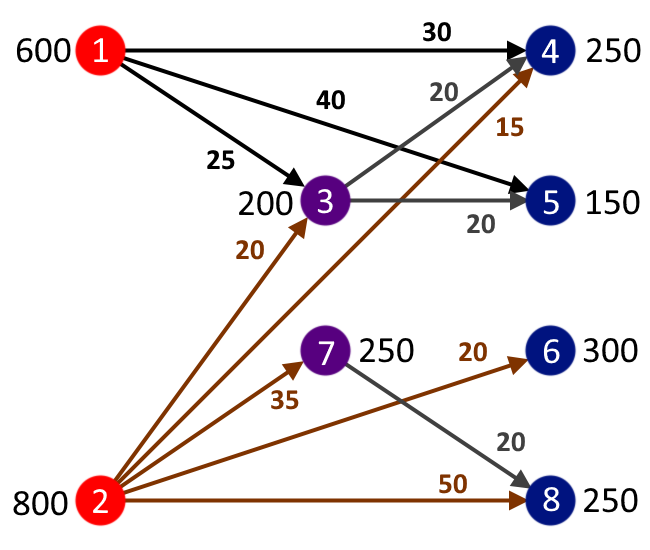

Resolvendo com `Julia`:

In [1]:
# Bibliotecas a serem usadas
using JuMP, GLPK

In [2]:
# Número de nós e suas capacidades e demandas
nodes = 1:8
b = [-600, -800, 200, 250, 150, 300, 250, 250]

# Nós iniciais e finais dos arcos
start_node = [1,1,1, 2,2,2,2,2, 3,3, 7]
end_node = [3,4,5, 3,4,6,7,8, 5,4, 8]

# Custos associados aos arcos
c = [25,30,40, 20,15,20,35,50, 20,20, 20]

# Arcos
links = Tuple( (start_node[i], end_node[i]) for i in 1:length(end_node) )
c_dict = Dict(links .=> c) 
links

((1, 3), (1, 4), (1, 5), (2, 3), (2, 4), (2, 6), (2, 7), (2, 8), (3, 5), (3, 4), (7, 8))

In [3]:
# Modelo
model = Model(GLPK.Optimizer)

# Variáveis
@variable(model, x[link in links]>=0)

# Função Objetivo
@objective(model, Min, sum(c_dict[link] * x[link] for link in links))

# Restrições
for i in nodes
   @constraint(model, -sum(x[(ii,j)] for (ii,j) in links if ii==i)
                   + sum(x[(j,ii)] for (j,ii) in links if ii==i) == b[i])
end

# Descrição do modelo
println(model)

Min 25 x[(1, 3)] + 30 x[(1, 4)] + 40 x[(1, 5)] + 20 x[(2, 3)] + 15 x[(2, 4)] + 20 x[(2, 6)] + 35 x[(2, 7)] + 50 x[(2, 8)] + 20 x[(3, 5)] + 20 x[(3, 4)] + 20 x[(7, 8)]
Subject to
 -x[(1, 3)] - x[(1, 4)] - x[(1, 5)] == -600
 -x[(2, 3)] - x[(2, 4)] - x[(2, 6)] - x[(2, 7)] - x[(2, 8)] == -800
 x[(1, 3)] + x[(2, 3)] - x[(3, 5)] - x[(3, 4)] == 200
 x[(1, 4)] + x[(2, 4)] + x[(3, 4)] == 250
 x[(1, 5)] + x[(3, 5)] == 150
 x[(2, 6)] == 300
 x[(2, 7)] - x[(7, 8)] == 250
 x[(2, 8)] + x[(7, 8)] == 250
 x[(1, 3)] >= 0
 x[(1, 4)] >= 0
 x[(1, 5)] >= 0
 x[(2, 3)] >= 0
 x[(2, 4)] >= 0
 x[(2, 6)] >= 0
 x[(2, 7)] >= 0
 x[(2, 8)] >= 0
 x[(3, 5)] >= 0
 x[(3, 4)] >= 0
 x[(7, 8)] >= 0



In [4]:
# Otimização do modelo
JuMP.optimize!(model)
obj = JuMP.objective_value(model)

# Valor ótimo
println("FO=", obj)

# 
for link in links
  println("x(",link,")= ",value(x[link]))
end

FO=45750.0
x((1, 3))= 200.0
x((1, 4))= 250.0
x((1, 5))= 150.0
x((2, 3))= 0.0
x((2, 4))= 0.0
x((2, 6))= 300.0
x((2, 7))= 250.0
x((2, 8))= 250.0
x((3, 5))= 0.0
x((3, 4))= 0.0
x((7, 8))= 0.0


Ou seja, a solução ótima é:

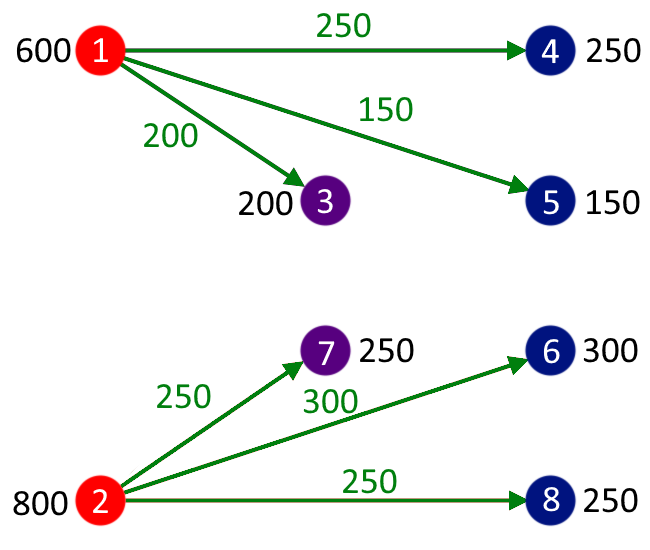

## Exemplo 2

Suponha uma fábrica que produz liquidificadores. O interesse é planejar a produção futura, de forma que:

- Minimiza-se os custos na produção de liquidificadores;  
- Planeja-se para os próximos 4 meses;  
- A capacidade de mensal produção na jornada normal é 150000 unidades, custando R\$ 15,00 cada;  
- A capacidade de produção em hora extra é de 50000 unidades, custando R\$ 22,00 cada;  
- A armazenagem de unidades produzidas no mês anterior custa R\$ 3,00 por unidade;  
- As demandas dos meses são 120000, 200000, 120000, e 180000 unidades. 

*Solução:*

Teremos 8 nós de capacidade, 4 meses $\times$ 2 tipos de jornada, e 5 de demanda, 4 meses + um *dummy* de 180000 unidades para igualar os totais de capacidade e demanda a 800000. Representando o problema na forma de um grafo:

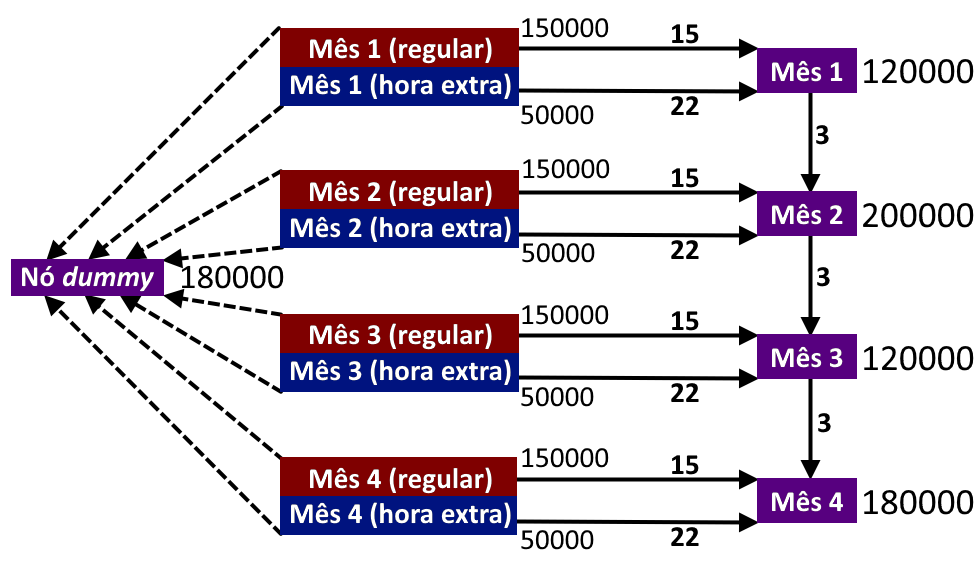

Resolvendo com `Julia`:

In [5]:
# Número de nós e suas capacidades e demandas
nodes = 1:13
b = [-150000,-50000, -150000,-50000, -150000,-50000, -150000,-50000,
    120000, 200000, 120000, 180000, 180000]

# Nós iniciais e finais dos arcos
start_node = [1,2, 3,4, 5,6, 7,8, 9, 10, 11, 1,2,3,4,5,6,7,8]
end_node = [9,9, 10,10, 11,11, 12,12, 10, 11, 12, 13,13,13,13,13,13,13,13]

# Custos associados aos arcos
c = [15,22, 15,22, 15,22, 15,22, 3, 3, 3, 50,50,50,50,50,50,50,50]

# Arcos
links = Tuple( (start_node[i], end_node[i]) for i in 1:length(end_node) )
c_dict = Dict(links .=> c) 
links

((1, 9), (2, 9), (3, 10), (4, 10), (5, 11), (6, 11), (7, 12), (8, 12), (9, 10), (10, 11), (11, 12), (1, 13), (2, 13), (3, 13), (4, 13), (5, 13), (6, 13), (7, 13), (8, 13))

In [6]:
# Modelo
model = Model(GLPK.Optimizer)

# Variáveis
@variable(model, x[link in links]>=0)

# Função Objetivo
@objective(model, Min, sum(c_dict[link] * x[link] for link in links))

# Restrições
for i in nodes
   @constraint(model, -sum(x[(ii,j)] for (ii,j) in links if ii==i)
                   + sum(x[(j,ii)] for (j,ii) in links if ii==i) == b[i])
end

# Descrição do modelo
println(model)

Min 15 x[(1, 9)] + 22 x[(2, 9)] + 15 x[(3, 10)] + 22 x[(4, 10)] + 15 x[(5, 11)] + 22 x[(6, 11)] + 15 x[(7, 12)] + 22 x[(8, 12)] + 3 x[(9, 10)] + 3 x[(10, 11)] + 3 x[(11, 12)] + 50 x[(1, 13)] + 50 x[(2, 13)] + 50 x[(3, 13)] + 50 x[(4, 13)] + 50 x[(5, 13)] + 50 x[(6, 13)] + 50 x[(7, 13)] + 50 x[(8, 13)]
Subject to
 -x[(1, 9)] - x[(1, 13)] == -150000
 -x[(2, 9)] - x[(2, 13)] == -50000
 -x[(3, 10)] - x[(3, 13)] == -150000
 -x[(4, 10)] - x[(4, 13)] == -50000
 -x[(5, 11)] - x[(5, 13)] == -150000
 -x[(6, 11)] - x[(6, 13)] == -50000
 -x[(7, 12)] - x[(7, 13)] == -150000
 -x[(8, 12)] - x[(8, 13)] == -50000
 x[(1, 9)] + x[(2, 9)] - x[(9, 10)] == 120000
 x[(3, 10)] + x[(4, 10)] + x[(9, 10)] - x[(10, 11)] == 200000
 x[(5, 11)] + x[(6, 11)] + x[(10, 11)] - x[(11, 12)] == 120000
 x[(7, 12)] + x[(8, 12)] + x[(11, 12)] == 180000
 x[(1, 13)] + x[(2, 13)] + x[(3, 13)] + x[(4, 13)] + x[(5, 13)] + x[(6, 13)] + x[(7, 13)] + x[(8, 13)] == 180000
 x[(1, 9)] >= 0
 x[(2, 9)] >= 0
 x[(3, 10)] >= 0
 x[(4, 10)] >=

In [7]:
# Otimização do modelo
JuMP.optimize!(model)
obj = JuMP.objective_value(model)

# Valor ótimo
println("FO=", obj)

# 
for link in links
  println("x(",link,")= ",value(x[link]))
end

FO=1.862e7
x((1, 9))= 150000.0
x((2, 9))= 0.0
x((3, 10))= 150000.0
x((4, 10))= 20000.0
x((5, 11))= 150000.0
x((6, 11))= 0.0
x((7, 12))= 150000.0
x((8, 12))= 0.0
x((9, 10))= 30000.0
x((10, 11))= 0.0
x((11, 12))= 30000.0
x((1, 13))= 0.0
x((2, 13))= 50000.0
x((3, 13))= 0.0
x((4, 13))= 30000.0
x((5, 13))= 0.0
x((6, 13))= 50000.0
x((7, 13))= 0.0
x((8, 13))= 50000.0


Ou seja, a solução ótima é:

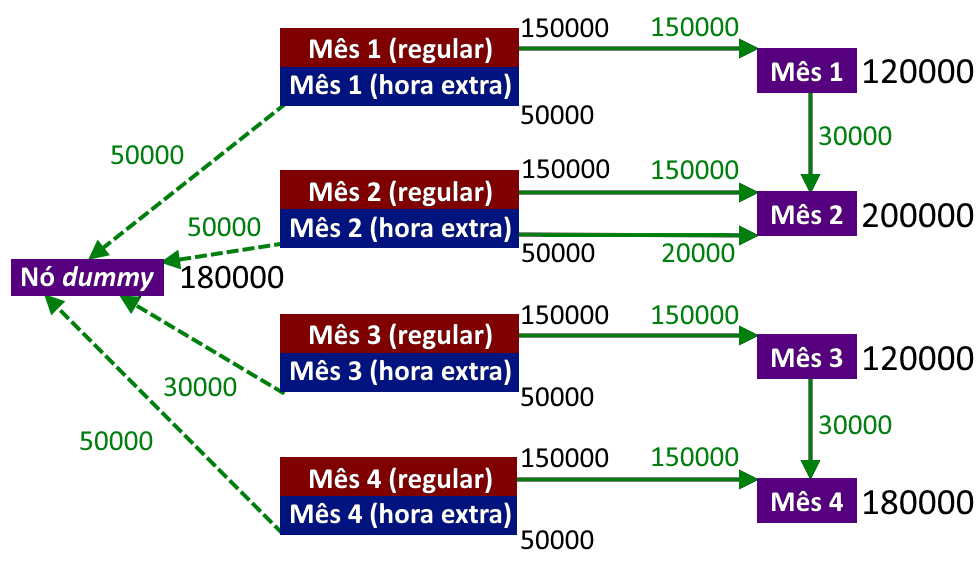

# PERT e CPM

**PERT** (***P**rogram **E**valuation and **R**eview **T**echnique*, técnica de evaluação e revisão de programas) e **CPM** (***C**ritical **P**ath **M**ethod*, método do caminho crítico) são técnicas usadas para analizar as tarefas necessárias para completar um projeto em termos de tempo decorrido e de relações de dependência de certos marcos.


## Exemplo 1

Suponha um projeto composto 5 estágios atingidos por atividades A, B, C, D, E, e F, com duração 3, 5, 4, 3, 7, e 2. Alguns estágios tem múltiplas tarefas como prerrequisitos, ou seja, só podem ser atingidos depois de se realizar todas as tarefas anteriores, de forma:

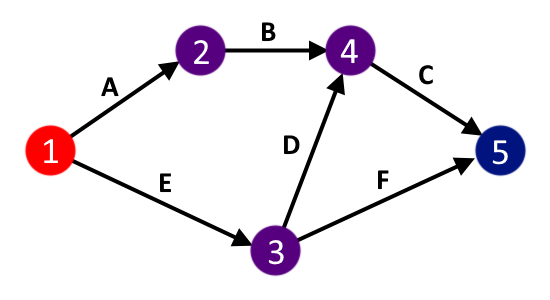

Sejam as seguintes datas associadas às tarefas:  
- **DCI**: **D**ata mais **c**edo de **í**nicio (caminho mais curto para iniciar a tarefa);  
    Ex: como A e E partem do estado inicial do projeto, elas têm DCI zero.
- **DCT**: **D**ata mais **c**edo de **t**érmino (**DCI** + duração da tarefa);  
- **DTI**: **D**ata mais **t**arde de **í**nicio (**DTT** - duração da tarefa);  
- **DTT**: **D**ata mais **t**arde de **t**érmino (caminho mais longo para terminar a tarefa).  
    Ex: como C e F levam ao estado final do projeto, elas têm DTT igual à duração do projeto. 

Teremos que:

| Atividade | Duração | DCI | DCT | DTI | DTT | Folga |
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
| A | 3 | 0 | 3 | 2 | 5 | 2 |
| B | 5 | 3 | 8 | 5 | 10 | 2 |
| C | 4 | 10 | 14 | 10 | 14 | 0 | 
| D | 3 | 7 | 10 | 7 | 10 | 0 |
| E | 7 | 0 | 7 | 0 | 7 | 0 |
| F | 2 | 7 | 9 | 12 | 14 | 5 |

Duração do projeto: 14.  

O caminho crítico, a parte que não admite folga e determina a duração do projeto, é $E-D-C$.

## Exemplo 2

Seja agora o projeto com tarefas A, B, C, D, E, F, G, de duração 7, 4, 3, 8, 3, 4, e 2, que é representado pelo grafo:

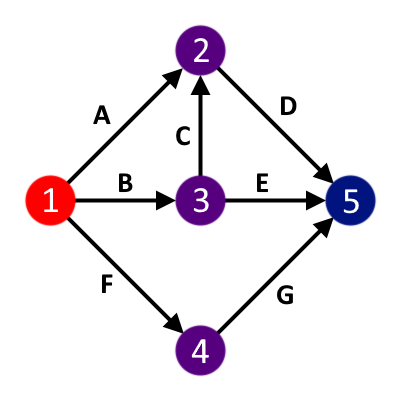

Teremos que

| Atividade | Duração | DCI | DCT | DTI | DTT | Folga |
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
| A | 7 | 0 | 7 | 0 | 7 | 0 |
| B | 4 | 0 | 4 | 0 | 4 | 0 |
| C | 3 | 4 | 7 | 4 | 7 | 0 | 
| D | 8 | 7 | 15 | 7 | 15 | 0 |
| E | 3 | 4 | 7 | 12 | 15 | 8 |
| F | 4 | 0 | 4 | 9 | 13 | 9 |
| G | 2 | 4 | 6 | 13 | 15 | 9 |


Duração do projeto: 15.  

O caminho crítico, a parte que não admite folga, é $A-B-C-D$.

## Exemplo 3

Seja agora um projeto com tarefas A, B, C, D, E, F, G, H, de durações 5, 3, 6, 2, 3, 4, 2, 3, que é representado pelo grafo:

| Atividade | Duração | DCI | DCT | DTI | DTT | Folga |
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
| A | 5 | 0 | 5 | 3 | 8 | 3 |
| B | 3 | 0 | 3 | 0 | 3 | 0 |
| C | 6 | 3 | 9 | 6 | 9 | 0 |
| D | 2 | 0 | 2 | 7 | 9 | 7 |
| E | 3 | 3 | 6 | 5 | 8 | 2 |
| F | 4 | 6 | 10 | 8 | 12 | 2 |
| G | 2 | 3 | 5 | 10 | 12 | 7 |
| H | 3 | 9 | 12 | 9 | 12 | 0 |

Duração do projeto: 12.  

O caminho crítico, a parte que não admite folga, é $B-C-H$.

O caminho crítico pode ser visto como o caminho de maior custo (tempo) para ser realizado, um "caminho máximo". Ou seja, pode ser encontrado pelo mesmo raciocínio usado no Problema de Caminho Mínimo, mas com o objetivo oposto na otimização.

Em `Julia`:

In [8]:
# Número de nós e seus tipos
nodes = 1:5
b=[-1,0,0,0,1]

# Inícios e fins dos 7 arcos
start_node = [1,1,3,1,3,2,3,4]
end_node = [2,3,4,4,2,5,5,5]

# Custos associados aos caminhos
c=[5,3,6,2,3,4,2,3]
#u=[Inf, Inf, Inf, Inf, Inf, Inf, Inf]

# Caminhos
links = Tuple( (start_node[i], end_node[i]) for i in 1:length(start_node) )
c_dict = Dict(links .=> c)
#u_dict = Dict(links .=> u)

links

((1, 2), (1, 3), (3, 4), (1, 4), (3, 2), (2, 5), (3, 5), (4, 5))

In [9]:
# Modelo
model = Model(GLPK.Optimizer)

# Variáveis (caminhos)
@variable(model, 0<= x[link in links])# <= u_dict[link])

# Função objetivo 
@objective(model, Max, sum(c_dict[link] * x[link] for link in links))

# Custos dos caminhos
for i in nodes
   @constraint(model, -sum(x[(ii,j)] for (ii,j) in links if ii==i)
                   + sum(x[(j,ii)] for (j,ii) in links if ii==i) == b[i])
end

# Descrição do modelo
println(model)

Max 5 x[(1, 2)] + 3 x[(1, 3)] + 6 x[(3, 4)] + 2 x[(1, 4)] + 3 x[(3, 2)] + 4 x[(2, 5)] + 2 x[(3, 5)] + 3 x[(4, 5)]
Subject to
 -x[(1, 2)] - x[(1, 3)] - x[(1, 4)] == -1
 x[(1, 2)] + x[(3, 2)] - x[(2, 5)] == 0
 x[(1, 3)] - x[(3, 4)] - x[(3, 2)] - x[(3, 5)] == 0
 x[(3, 4)] + x[(1, 4)] - x[(4, 5)] == 0
 x[(2, 5)] + x[(3, 5)] + x[(4, 5)] == 1
 x[(1, 2)] >= 0
 x[(1, 3)] >= 0
 x[(3, 4)] >= 0
 x[(1, 4)] >= 0
 x[(3, 2)] >= 0
 x[(2, 5)] >= 0
 x[(3, 5)] >= 0
 x[(4, 5)] >= 0



In [10]:
# Otimização do modelo
JuMP.optimize!(model)
obj = JuMP.objective_value(model)

# Custo mínimo
println(obj)

# Caminho do custo mínimo
println("Função Objetivo: FO=", obj)
for link in links
  println("Valor de x",link," = ",value(x[link]))
end

12.0
Função Objetivo: FO=12.0
Valor de x(1, 2) = 0.0
Valor de x(1, 3) = 1.0
Valor de x(3, 4) = 1.0
Valor de x(1, 4) = 0.0
Valor de x(3, 2) = 0.0
Valor de x(2, 5) = 0.0
Valor de x(3, 5) = 0.0
Valor de x(4, 5) = 1.0


Ou seja, o caminho crítico é:

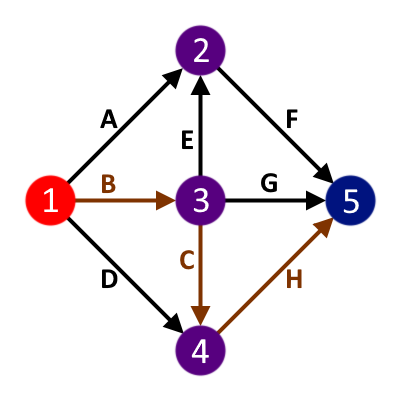